<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 17 - Model Misspecification
***

# Model Misspecification
By Evgenia "Jenny" Nitishinskaya and Delaney Mackenzie

Model specification refers to the selection of the general function that we are fitting to the data. We need to select:
* the dependent variable(s)
* the independent variable(s)
* the functional form

For instance, we may assume that the dependent variable is a linear function of two independent variables. If the model is not correctly specified, regression assumptions will be violated and the model will not be accurate. Below we define and explain many of the common model specification errors.

## Exclusion of important variables

If we omit a variable which is uncorrelated with the variables that we do include, we will simply not explain the dependent variable as well as we could. However, if the omitted variable (say, $X_2$) is correlated with the included variable ($X_1$), then the omission additionally affects the model. The coefficient of $X_1$ and the constant term in the regression will be biased by trying to compensate for the omission of $X_2$. This can lead us to overestimate the effect of $X_1$ on the dependent variable. Also, estimated values of the coefficients and the estimated standard errors will be inconsistent.

In particular, we may be led to believe that two variables have a causal relationship because of their high correlation, when in fact they are both caused by a third. For instance, if two stocks both follow the market, or two quantities both tend to increase with time, they will be highly correlated. 

In [1]:
# Import the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

In [2]:
# Pull the pricing data for our two stocks and S&P 500
from quantrocket.master import get_securities
from quantrocket import get_prices

securities = get_securities(symbols=["SPY", "AAPL", "JNJ"], vendors='usstock')

start = '2013-01-01'
end = '2015-01-01'

closes = get_prices('usstock-free-1min', data_frequency='daily', sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']

sids_to_symbols = securities.Symbol.to_dict()
closes = closes.rename(columns=sids_to_symbols)

bench = closes['SPY']
a1 = closes['JNJ']
a2 = closes['AAPL']

# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print("R-squared values of linear regression")
print("JNJ and AAPL:", slr12.rsquared)
print("JNJ and SPY:", slrb1.rsquared)
print("AAPL and SPY:", slrb2.rsquared)

R-squared values of linear regression
JNJ and AAPL: 0.7561816151426892
JNJ and SPY: 0.9537085501322876
AAPL and SPY: 0.8241935110041808


It's hard to see consistency, or lack of it, since it is asymptotic and probabilistic. However, we can extend our sample period to see how the R-squared value changes. The correlation between the stocks and the market seems to persist, while the correlation between the two stocks drops. So we would be better off predicting the stock prices from the market price than from each other.

In [3]:
# Pull pricing data from further back
start = '2009-01-01'
end = '2015-01-01'

closes = get_prices('usstock-free-1min', data_frequency='daily', sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']
closes = closes.rename(columns=sids_to_symbols)

bench = closes['SPY']
a1 = closes['JNJ']
a2 = closes['AAPL']

# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print("R-squared values of linear regression")
print("JNJ and AAPL:", slr12.rsquared)
print("JNJ and SPY:", slrb1.rsquared)
print("AAPL and SPY:", slrb2.rsquared)

R-squared values of linear regression
JNJ and AAPL: 0.662057671399793
JNJ and SPY: 0.9498743121988567
AAPL and SPY: 0.7888478832212861


The best way to avoid this issue is to choose the independent variables which you have reason to believe will be good predictors of the dependent variable before starting the regression analysis. "Before" is key: it's important not to pick variables just based on how good the regression analysis looks because that leads to overfitting.

## Inclusion of unnecessary variables

Conversely, we can have a model which includes too many independent variables. If we include a truly unnecessary variable, we will have a lower adjusted R-squared and less precise estimates of the other regression coefficients. That is, our analysis of the model will be weakened, but the model itself will not change.

If we include variables that are only mostly irrelevant, however, we can artificially improve the fit and the R-squared of our model by adding bits of the slightly-correlated variables to conform to the sample data. This runs the risk of overfitting, since the small adjustments we make are sample-specific. For example, below we run a regression with MSFT price as the independent variable and AAPL price as the dependent variable (which makes some sense as they are in the same sector) and then run another regression with three random other stocks added in.

SLR R-squared: 0.8434259550549307
MLR R-squared: 0.9170955837349951


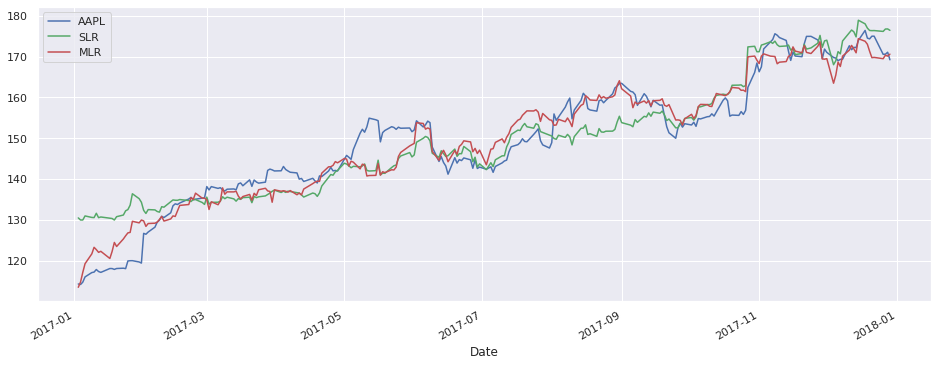

In [4]:
# Load one year's worth of pricing data for five different assets

securities = get_securities(symbols=["AAPL", "MSFT", "JNJ", "XOM", "MON"], vendors='usstock')

start = '2017-01-01'
end = '2018-01-01'

closes = get_prices("usstock-free-1min", data_frequency='daily', sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']

sids_to_symbols = securities.Symbol.to_dict()
closes = closes.rename(columns=sids_to_symbols)

x1 = closes['MSFT']
x2 = closes['JNJ']
x3 = closes['MON']
x4 = closes['XOM']
y = closes['AAPL']

# Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params.iloc[0] + slr.params.iloc[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params.iloc[0] + mlr.params.iloc[1]*x1 + mlr.params.iloc[2]*x2 + mlr.params.iloc[3]*x3 + mlr.params.iloc[4]*x4

# Compute adjusted R-squared for the two different models
print('SLR R-squared:', slr.rsquared_adj)
print('MLR R-squared:', mlr.rsquared_adj)

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.legend(['AAPL', 'SLR', 'MLR']);

We are able to tune the model with more variables more precisely to the data. Note that although adjusted R-squared penalizes us for using more variables, the number of samples here is so large that the adjustment is tiny. Let's see what happens if we use the same linear models to predict the price of AAPL for the next six months:

SLR R-squared: -3.17289751446555
MLR R-squared: -6.131583377986047


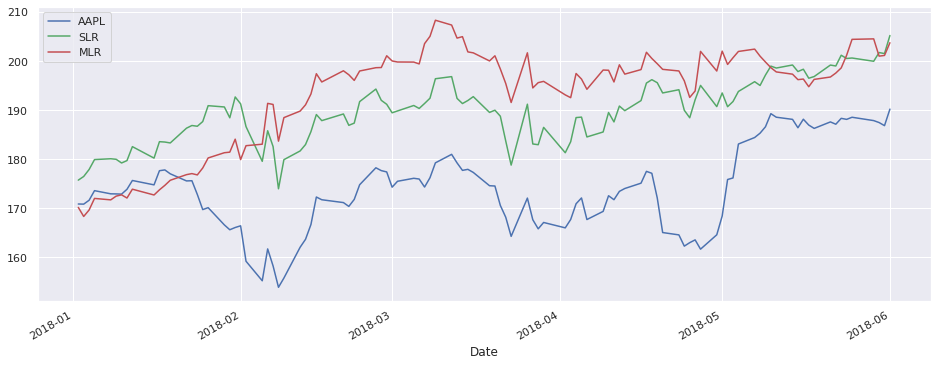

In [5]:
# Load a half year of pricing data
start = '2018-01-01'
end = '2018-06-01'

closes = get_prices("usstock-free-1min", data_frequency='daily', sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']
closes = closes.rename(columns=sids_to_symbols)

x1 = closes['MSFT']
x2 = closes['JNJ']
x3 = closes['MON']
x4 = closes['XOM']
y = closes['AAPL']

# Extend our model from before to the new time period
slr_prediction2 = slr.params.iloc[0] + slr.params.iloc[1]*x1
mlr_prediction2 = mlr.params.iloc[0] + mlr.params.iloc[1]*x1 + mlr.params.iloc[2]*x2 + mlr.params.iloc[3]*x3 + mlr.params.iloc[4]*x4

# Compute adjusted R-squared over the extended time period
adj = float(len(y) - 1)/(len(y) - 5) # Compute adjustment factor
SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print('SLR R-squared:', 1 - adj*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print('MLR R-squared:', 1 - adj*SSRm/SST)

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.legend(['AAPL', 'SLR', 'MLR']);

Now both models are performing rather poorly - that is, they do not hold up out of sample - but in particular the model from the multiple linear regression is now doing worse than the model from the single linear regression. Although this performance could have any number of causes, we should not be surprised since we have no reason to believe that, say, Monsanto stock has actual explanatory power in this situation.

## Errors in independent variables

If we use indices or dates as our independent variables, they are error-free. However, when we wish to use the value of a stock $X_t$ as an independent variable, we can only measure the price, which is full of small, random fluctuations. So we actually observe $Z_t = X_t + u_t$ for some error $u_t$. Our model is
$$ Y_t = b_0 + b_1 X_t + \epsilon_t $$

that is, that some variable is linearly related to the value of a stock. But since we only know the value of $Z_t$, we use the model
$$ Y_t = b_0 + b_1 Z_t + (-b_1u_t + \epsilon_t) $$

If $u_t$ is not correlated with $X_t$, then it will be correlated with $Z_t$, and so the error term $-b_1u_t + \epsilon_t$ will be correlated with our independent variable $Z_t$. Consequently, the coefficients will be biased and inconsistent. In particular, $b_1$ will be biased downward.

## Incorrect functional form

After we pick the variables we wish to include, we need to specify a shape for the function. Although a regression requires that the function be linear in the coefficients, we can manipulate the variables to achieve various types of functions. For instance, the model $Y_i = b_0 + b_1 X_i^2 + \epsilon_i$ gives a quadratic relationship between $X$ and $Y$, while the log-linear model $\ln Y_i = b_0 + b_1 X_i + \epsilon_i$ gives an exponential one. Generally we select the form based on our expectation of the relationship: for example, a log-linear model is good when we expect the <i>rate of growth</i> of $Y$ to be related to $X$.

If the wrong form is selected, then we may be unable to get a good fit. In fact, the model may lead to absurd conclusions. For example, if we use a linear model where a logarithmic one would have been more appropriate, we may predict that the number of companies in a certain category becomes negative instead of approaching zero.

We also have to be careful not to pick a functional form that overfits the data. Arbitrarily using high-degree polynomials leads to overfitting since they have more degrees of freedom. Another issue is data-mining: if we try different models until we find the one that looks best, we are overfitting to the sample at the expense of future predictivity.

## Pooling different populations

If we attempt to use one model for two populations for which separate models would be more appropriate, we get results that are misleading in one direction or the other. For instance, if we mix data about men's and women's wages, there may be too much spread to find a model that fits well, as in the artificial example below.

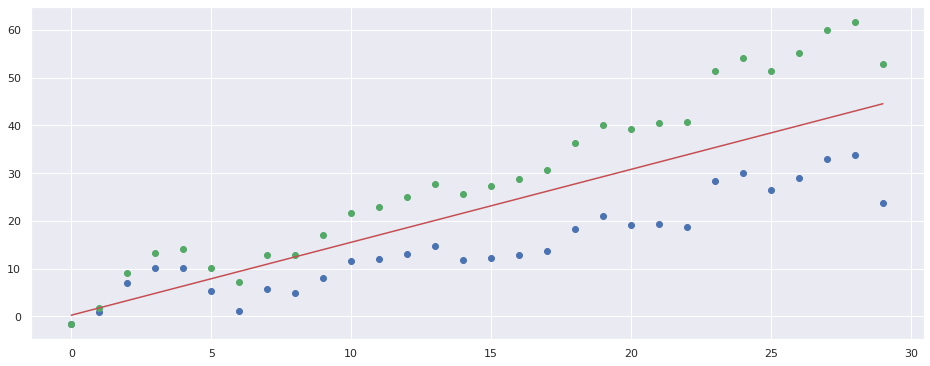

In [6]:
# Generate two artificial samples and pool them
sample1 = np.arange(30) + 4*np.random.randn(30)
sample2 = sample1 + np.arange(30)
pool = np.hstack((sample1, sample2))

# Run a regression on the pooled data, with the independent variable being the original indices
model = regression.linear_model.OLS(pool, sm.add_constant(np.hstack((np.arange(30),np.arange(30))))).fit()

# Plot the two samples along with the regression line
plt.scatter(np.arange(30), sample1, color='b')
plt.scatter(np.arange(30), sample2, color='g')
plt.plot(model.params[0] + model.params[1]*np.arange(30), color='r');

It's clear that two separate models for the two datasets would be more appropriate. Note that, as above, this can lead to assumption violations like heteroskedasticity and errors that are not normally distributed.

Conversely, we can pool sets of observations which separately demonstrate no correlation, but do appear to fit a correlation model when taken together. To see why this might be a problem, consider a model that compares companies' free cash flow with cash flow from operations. Below we see that there is a correlation between the two for transportation companies with market cap over $100 million. However, if we scale both datasets by the company revenue, the fit is much less significant. That is, the correlation between free cash flow and cash flow from operations is largely due to company size, and thus doesn't give us any information.

To run this test, we use the Pipeline API and Sharadar fundamentals. First, we define a pipeline that screens for transportation companies with market cap over \$100 million.

In [7]:
from zipline.pipeline import Pipeline, sharadar, master
from zipline.research import run_pipeline

fundamentals = sharadar.Fundamentals.slice(dimension='ARQ', period_offset=0)

pipeline = Pipeline(
    columns={
        "free_cash_flow": fundamentals.FCF.latest,
        "operating_cash_flow": fundamentals.NCFO.latest,
        "total_revenue": fundamentals.REVENUE.latest
    },
    screen=fundamentals.MARKETCAP.latest > 1e8,
    initial_universe=master.SecuritiesMaster.sharadar_FamaIndustry.latest.eq('Transportation')
)

We then run the pipeline, select the results for a single date, and run the regression:

R-squared value of model: 0.4888431067969575


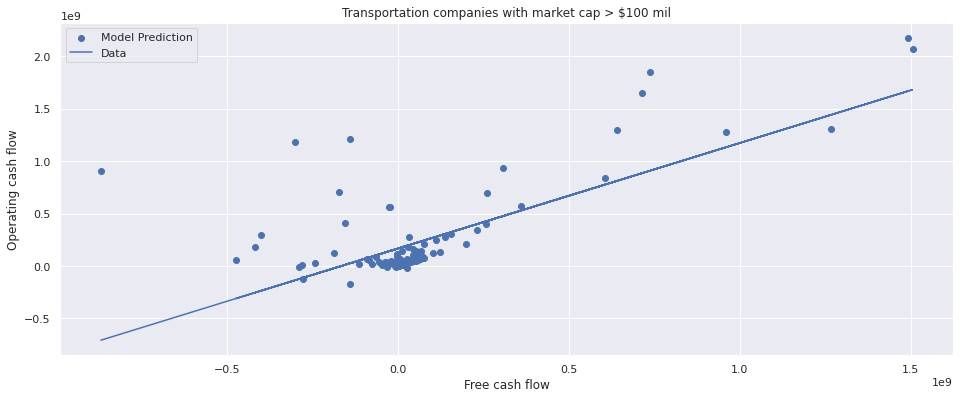

In [8]:
data = run_pipeline(pipeline, start_date="2015-12-01", end_date="2015-12-31", bundle='sharadar-1d')
data = data.xs('2015-12-31')

# Drop missing data
data.dropna(inplace=True)

# Run linear regression and print R-squared value to evaluate the goodness of the fit 
unscaled_model = regression.linear_model.OLS(data['operating_cash_flow'],
                                    sm.add_constant(data['free_cash_flow'])).fit()
prediction = unscaled_model.params.iloc[0] + unscaled_model.params.iloc[1]*data['free_cash_flow']
print('R-squared value of model:', unscaled_model.rsquared)

# Plot the raw data for visualization
plt.scatter(data['free_cash_flow'], data['operating_cash_flow'])
plt.plot(data['free_cash_flow'], prediction)
plt.legend(['Model Prediction', 'Data'])
plt.xlabel('Free cash flow')
plt.ylabel('Operating cash flow')
plt.title('Transportation companies with market cap > $100 mil');

Next we scale by revenue and run the regression again:

R-squared value of scaled model: 0.08582368595314782


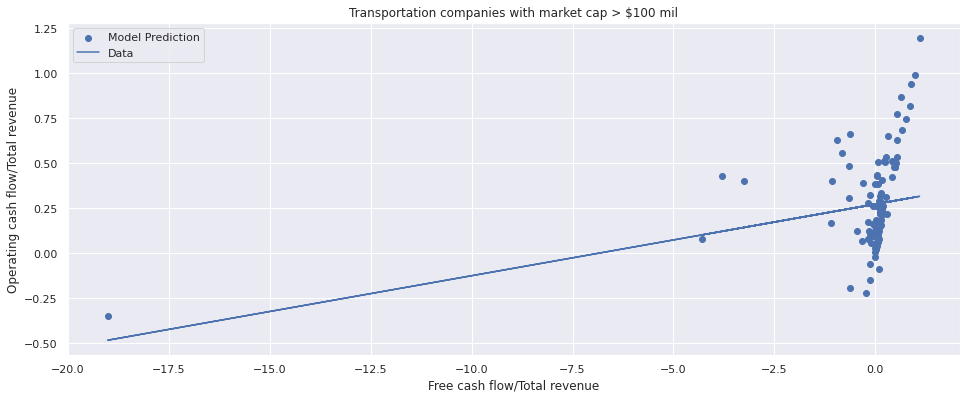

In [9]:
# drop rows with 0 revenue to avoid division by zero
data = data[data.total_revenue > 0]

# Run linear regression with inputs scaled by total revenue
scaled_model = regression.linear_model.OLS(
    data['operating_cash_flow']/data['total_revenue'],
    sm.add_constant(data['free_cash_flow']/data['total_revenue']), missing='drop').fit()
print('R-squared value of scaled model:', scaled_model.rsquared)

prediction = scaled_model.params.iloc[0] + scaled_model.params.iloc[1]*(data['free_cash_flow']/data['total_revenue'])

# Plot the scaled data
plt.scatter(data['free_cash_flow']/data['total_revenue'],
            data['operating_cash_flow']/data['total_revenue'])
plt.plot(data['free_cash_flow']/data['total_revenue'], prediction)
plt.legend(['Model Prediction', 'Data'])
plt.xlabel('Free cash flow/Total revenue')
plt.ylabel('Operating cash flow/Total revenue')
plt.title('Transportation companies with market cap > $100 mil');

In general, if we wish to compare data from different populations, we can either analyze them separately or try to adjust for the differences between them. Often we express the variables as ratios, such as scaling by company revenue or by the average wages of each population.

## Nonstationary time series

A stationary process is one whose joint probability distribution does not change with time. In particular, its mean and variance are constant through time. When we apply regression models to time series, we must make the additional assumption that they are stationary. Otherwise, the t-statistics for the parameters will not be valid.

A random walk is a process for which the best estimate for the next value is the previous value; if you were to walk randomly, your location after the each step would be somewhere near your location before the step but in an unpredictable direction. Formally, such a one-dimensional walk is described by the equation
$$ x_t = x_{t-1} + \epsilon_t $$

where the error $\epsilon_t$ is homoskedastic, has mean zero, and is not autocorrelated. For example, exchange rates are often assumed to be random walks. Random walks have variance increasing with time, and are therefore not stationary. They are subject to spurious results, and two random walks will appear highly correlated very often. Try running the code below several times:

### All the walks

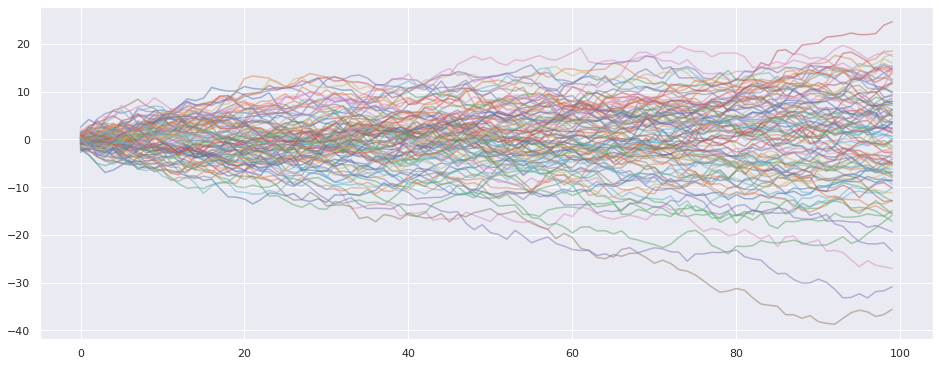

In [10]:
# Generate normally distributed errors
randos = [np.random.randn(100) for i in range(100)]
y = np.random.randn(100)
# Generate random walks
randows = [[sum(rando[:i+1]) for i in range(100)] for rando in randos]
yw = [sum(y[:i+1]) for i in range(100)]

for i in range(100):
    plt.plot(randows[i], alpha=0.5)

### Just those correlated with a randomly chosen one

Linearly related walks out of 100: 32


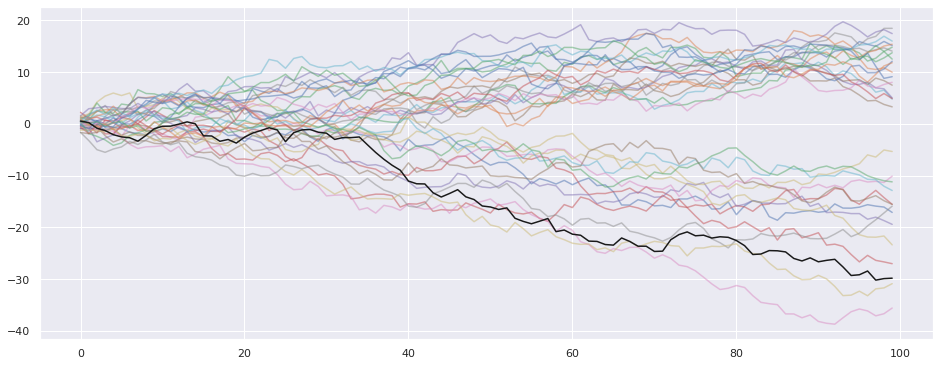

In [11]:
# Compute R-squared of linear regression for each element of randows with yw
rs = [regression.linear_model.OLS(yw, x).fit().rsquared for x in randows]
                    
# Plot and count the random walks that have R-squared with yw > .8
rcount = 0
for i in range(100):
    if rs[i] > .8:
        rcount += 1
        plt.plot(randows[i], alpha=0.5)
print('Linearly related walks out of 100:', rcount)

# Plot yw
plt.plot(yw, color='k');

The reason for the two branches above is that a linear fit works well for both positively and negatively correlated variables.

The result is even more extreme if we look at the random walks with significant correlation, according to the p-values of their correlation coefficients:

Significantly correlated walks out of 100: 90


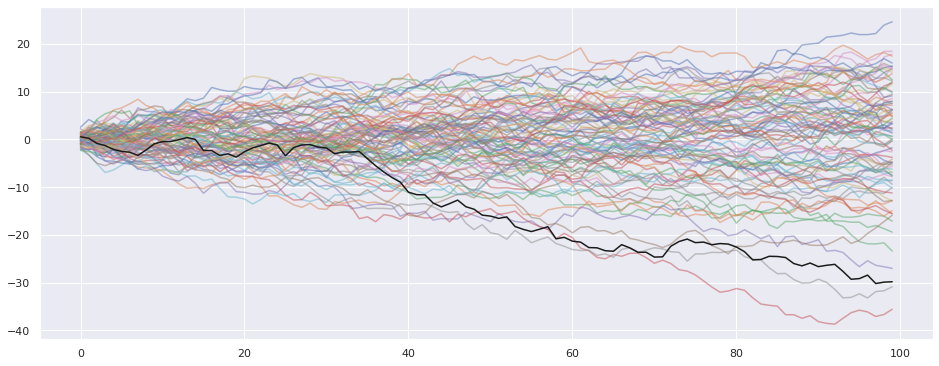

In [12]:
from scipy.stats import pearsonr

# Compute correlation coefficients (Pearson r) and record their p-values
ps = [pearsonr(yw, x)[1] for x in randows]
                    
# Plot and count the random walks that have p-value of correlation with yw < 0.05
pcount = 0
for i in range(100):
    if ps[i] < .05:
        pcount += 1
        plt.plot(randows[i], alpha=0.5)
print('Significantly correlated walks out of 100:', pcount)

# Plot yw
plt.plot(yw, color='k');

Because of the high probability of spurious results, the fit statistics that we compute when regressing on random walks are invalid. Furthermore, the parameter estimates are inconsistent.

We can detect random walks and related time series (such as a random walk with drift) by checking for the presence of a <i>unit root</i> in the time series; that is, whether or not it appears to follow the equation $x_t = x_{t-1} + \epsilon_t$. One method is using the Dickey-Fuller test:

In [13]:
from statsmodels.tsa.stattools import adfuller

# Compute the p-value of the Dickey-Fuller statistic to test the null hypothesis that yw has a unit root
print(adfuller(yw)[1])

0.9393236647801395


Therefore we cannot reject the hypothesis that `yw` has a unit root (as we know it does, by construction). If we know that a time series has a unit root and we would like to analyze it anyway, we can model instead the first differenced series $y_t = x_t - x_{t-1}$ if that is stationary, and use it to predict future values of $x$. We can also use regression if both the dependent and independent variables are time series with unit roots and the two are cointegrated.

## References
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle

---

**Next Lecture:** [Residual Analysis](Lecture18-Residual-Analysis.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*